This notebook trains the CWW+SB4 templates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, copy
from scipy.interpolate import interp1d
from scipy.signal import medfilt

from modules.galaxyphoto import get_bandpass_dict, Sed
from modules.photomatching import create_training_sets
from modules.training import train_templates

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

Load the filters

In [3]:
bandpass_dict = get_bandpass_dict()

Load the galaxy redshift catalog

In [4]:
with open('data/training_catalog.pkl', 'rb') as input:
    galaxies = pickle.load(input)

Load the CWW+SB4 templates

In [6]:
cwwsb4_templates = dict()
step = 100
lambda_min = 10
lambda_max = 15000

x, y = np.loadtxt('templates/El_B2004a.sed',unpack=True)
sed = Sed()
sed.wavelen = np.arange(lambda_min,lambda_max,step,dtype=float)
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['El'] = sed

x, y = np.loadtxt('templates/Sbc_B2004a.sed',unpack=True)
sed = Sed()
sed.wavelen = np.arange(lambda_min,lambda_max,step,dtype=float)
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['Sbc'] = sed

x, y = np.loadtxt('templates/Scd_B2004a.sed',unpack=True)
sed = Sed()
sed.wavelen = np.arange(lambda_min,lambda_max,step,dtype=float)
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['Scd'] = sed

x, y = np.loadtxt('templates/Im_B2004a.sed',unpack=True)
sed = Sed()
sed.wavelen = np.arange(lambda_min,lambda_max,step,dtype=float)
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['Im'] = sed

x, y = np.loadtxt('templates/SB3_B2004a.sed',unpack=True)
sed = Sed()
sed.wavelen = np.arange(lambda_min,lambda_max,step,dtype=float)
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['SB3'] = sed

x, y = np.loadtxt('templates/SB2_B2004a.sed',unpack=True)
sed = Sed()
sed.wavelen = np.arange(lambda_min,lambda_max,step,dtype=float)
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['SB2'] = sed

# note I will lower the spectral line in SB2 because it creates problems in
# the template training
template = cwwsb4_templates['SB2']
idx = np.fabs(template.wavelen-5000).argmin()
template.flambda[idx] /= 4

x, y = np.loadtxt('templates/ssp_25Myr_z008.sed',unpack=True)
sed = Sed()
sed.wavelen = np.arange(lambda_min,lambda_max,step,dtype=float)
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['25Myr'] = sed

x, y = np.loadtxt('templates/ssp_5Myr_z008.sed',unpack=True)
sed = Sed()
sed.wavelen = np.arange(lambda_min,lambda_max,step,dtype=float)
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['5Myr'] = sed

Create training sets and plot them

In [8]:
%%time
training_sets = create_training_sets(galaxies, cwwsb4_templates, bandpass_dict)

CPU times: user 10.9 s, sys: 857 ms, total: 11.8 s
Wall time: 51.2 s


Number of galaxies in each training set:
[9266, 18013, 26139, 15428, 8686, 4038, 384, 26]


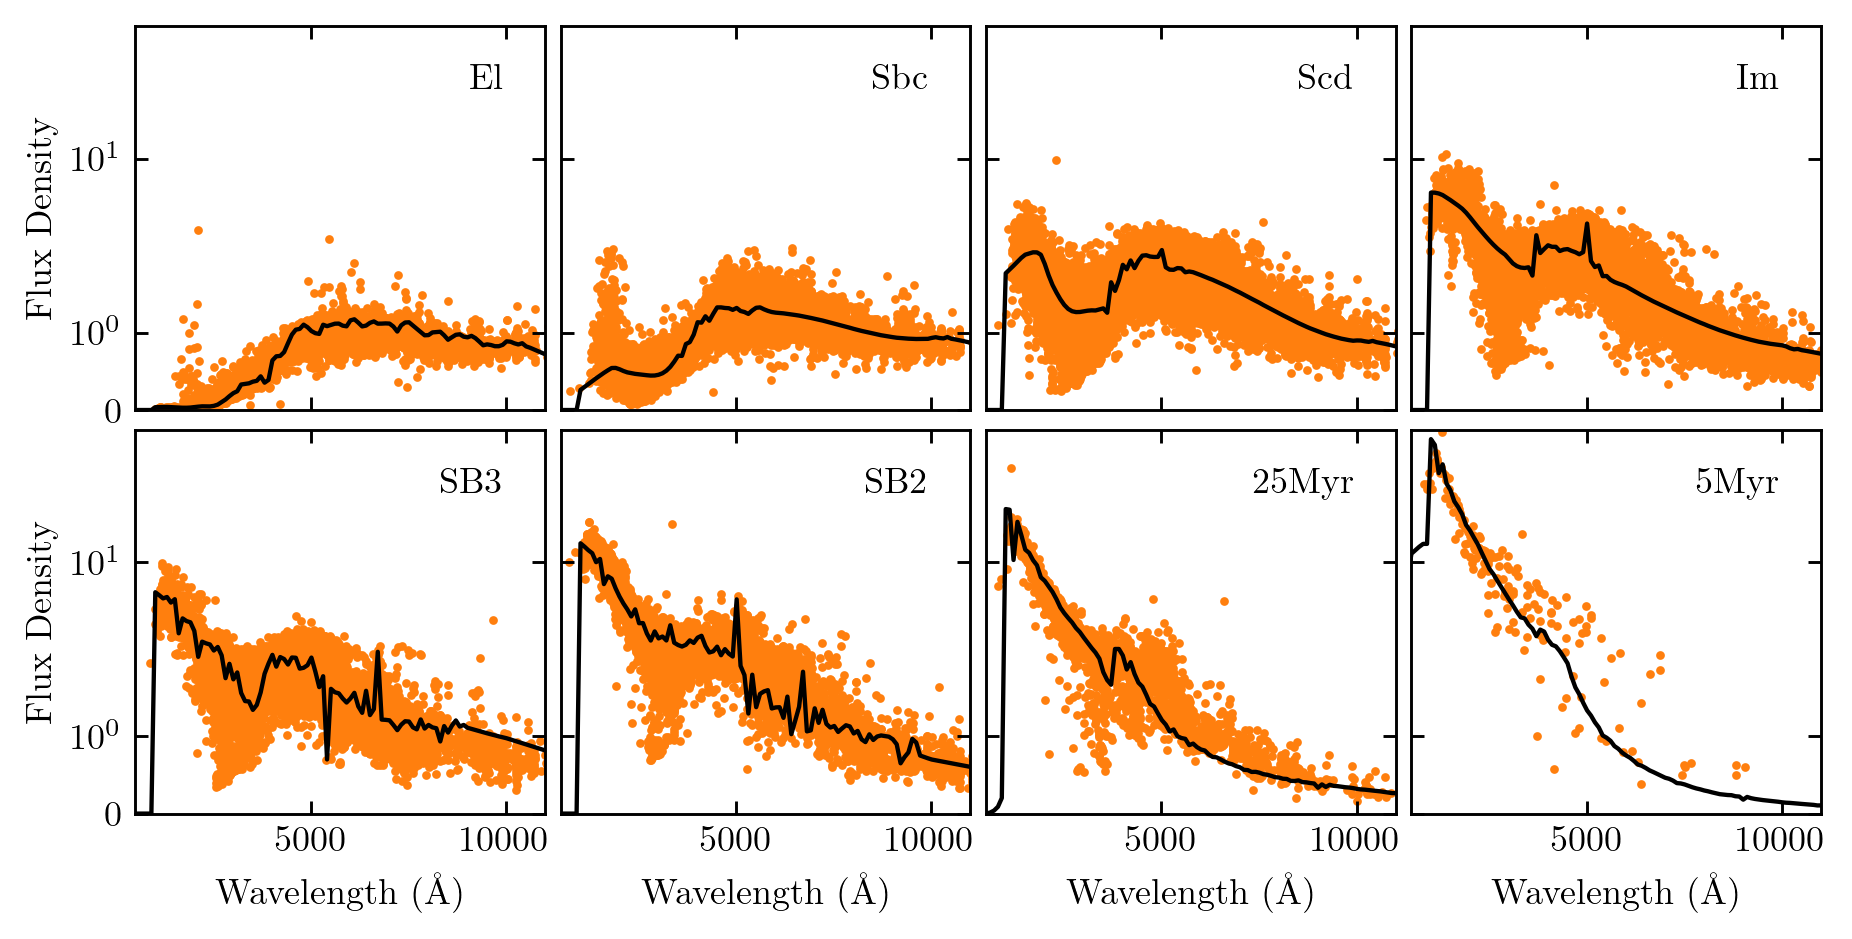

In [12]:
fig, axes = plt.subplots(2,4,sharex='all',sharey='all',figsize=(twocol,twocol*1/2))

print("Number of galaxies in each training set:")
print([len(i) for i in training_sets.values()])

for key,ax in zip(training_sets.keys(),axes.flatten()):
    
    tset = training_sets[key]
    wavelen = [w for galaxy in tset for w in galaxy.wavelen]
    fluxes = [f for galaxy in tset for f in galaxy.fluxes]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    del tset, wavelen, fluxes
    
    template = cwwsb4_templates[key]
    ax.plot(template.wavelen, template.flambda, c="k")
    
    ax.text(0.9,0.9,key,transform=ax.transAxes,ha="right",va="top")

plt.xlim(500,11000)
plt.ylim(0,90)
plt.yscale('symlog')

for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')

fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
plt.show()

#fig.savefig('plots/cwwsb4_untrained.png')

Now train the templates

In [13]:
%%time
trained_templates, history = train_templates(galaxies, cwwsb4_templates, bandpass_dict, w=2, dmse_stop=0.03)

Columns: Template, number of perturbations, initial/final wMSE
Round 1
El        3       37.6       30.2
Sbc       2       65.8       57.4
Scd       2      148.0      138.7
Im        2      247.4      223.1
SB3       2      250.1      219.0
SB2       2      814.5      716.8
25Myr     3     2759.6     1999.2
5Myr      5    75659.0    40266.0
Round 2
El        1       28.1       27.3
Sbc       0       58.4       58.4
Scd       2      134.2      126.9
Im        2      187.2      178.3
SB3       2      192.3      180.6
SB2       1      519.4      503.9
25Myr     1     3458.0     3362.4
5Myr      3    24818.6    14898.6
Round 3
El        1       28.2       27.7
Sbc       0       57.2       57.2
Scd       2      138.0      131.4
Im        0      183.1      183.1
SB3       2      174.3      164.9
SB2       0      489.6      489.6
25Myr     2     1487.9     1423.5
5Myr      2    16606.1    15800.6
Round 4
El        0       27.9       27.9
Sbc       2       59.8       57.0
Scd       2      136.

Generate final training sets

In [15]:
final_sets = create_training_sets(galaxies, trained_templates, bandpass_dict)

Save the results!

In [14]:
"""for template in trained_templates:
    file = open('templates/'+template+'_trained.sed','w')
    x = copy.copy(trained_templates[template].wavelen)
    y = copy.copy(trained_templates[template].flambda)
    # upsample to every 10 angstroms
    xnew = np.arange(x[0],x[-1],10)
    ynew = np.interp(xnew,x,y)
    for i in range(len(xnew)):
        file.write("{0:<10.2f}{1:<10.4f}\n".format(xnew[i],ynew[i]))
    file.close()

f = open("templates/cwwsb4_training_history.pkl","wb")
pickle.dump(history,f)
f.close()""";

Plot the results

In [7]:
# Load the trained templates from files if you didn't run the training algorithm
trained_templates = dict()
for template in cwwsb4_templates:
    x,y = np.loadtxt('templates/'+template+'_trained.sed',unpack=True)
    trained_templates[template] = Sed(x,y)
    
final_sets = create_training_sets(galaxies, trained_templates, bandpass_dict)

Number of galaxies in each training set:
[9506, 11782, 13313, 16916, 15755, 9527, 1381, 3800]


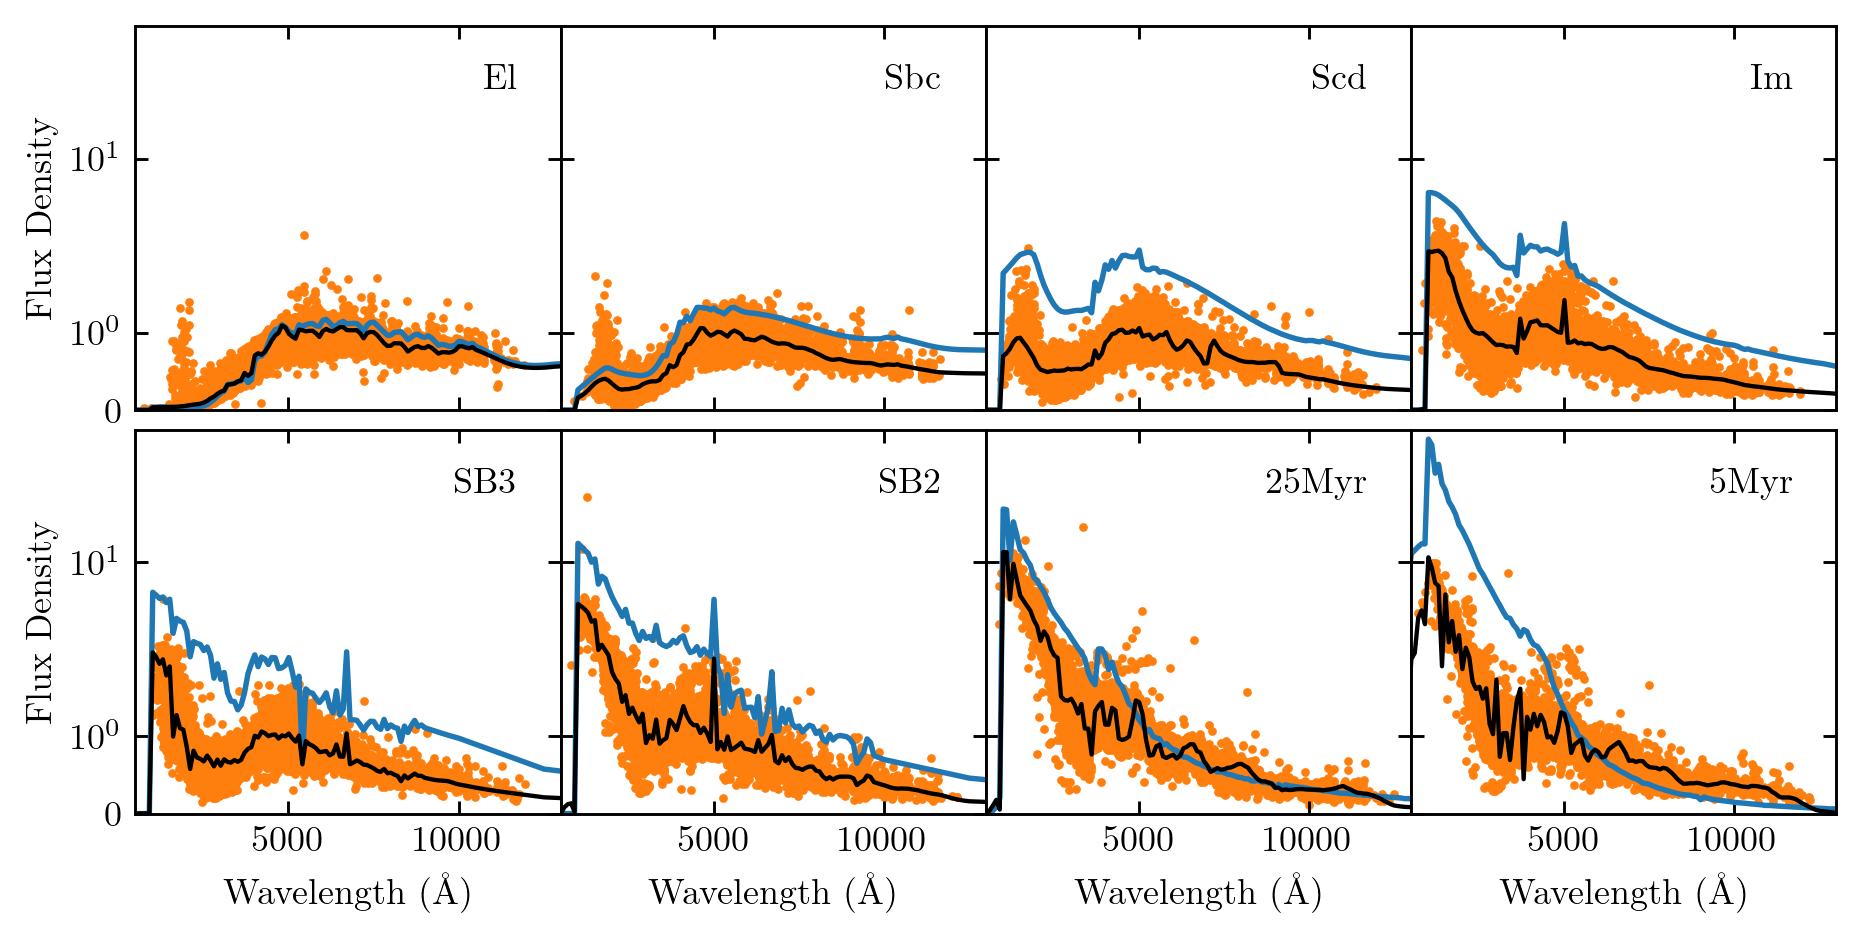

In [24]:
fig, axes = plt.subplots(2,4,sharex='all',sharey='all',figsize=(twocol,1/2*twocol))

print("Number of galaxies in each training set:")
print([len(i) for i in final_sets.values()])

for key,ax in zip(final_sets.keys(),axes.flatten()):
    
    tset = final_sets[key]
    wavelen = [w for galaxy in tset for w in galaxy.wavelen]
    fluxes = [f for galaxy in tset for f in galaxy.fluxes]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    del tset, wavelen, fluxes
    
    sed = cwwsb4_templates[key]
    ax.plot(sed.wavelen, sed.flambda, ls="-", c="C0", lw=1.5)
    
    sed = trained_templates[key]
    ax.plot(sed.wavelen, sed.flambda, ls="-", c="k")
    
    ax.text(0.9,0.9,key,transform=ax.transAxes,ha="right",va="top")

plt.xlim(500,13000)
plt.ylim(0,90)
plt.yscale('symlog')#,linthreshy=3)

for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')
    
fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
plt.show()

#fig.savefig('plots/cwwsb4_trained.png')

Need to renormalize the original templates

In [35]:
original_normed = copy.deepcopy(cwwsb4_templates)

# restore the big spectral line in SB2
x, y = np.loadtxt('templates/SB2_B2004a.sed',unpack=True)
sed = Sed()
sed.wavelen = np.arange(lambda_min,lambda_max,step,dtype=float)
sed.flambda = np.interp(sed.wavelen,x,y)
original_normed['SB2'] = sed

# now renorm all the templates around 5000 angstroms
for template in original_normed.values():
    X = np.arange(template.wavelen[0], template.wavelen[-1], 100)
    Y = np.interp(X, template.wavelen, template.flambda)
    Y = medfilt(Y, kernel_size=9)
    idx = np.fabs(template.wavelen - 5000).argmin()
    template.flambda /= Y[idx]

In [ ]:
fig, axes = plt.subplots(2,4,sharex='all',sharey='all',figsize=(twocol,1/2*twocol))

print("Number of galaxies in each training set:")
print([len(i) for i in final_sets.values()])

for key,ax in zip(final_sets.keys(),axes.flatten()):
    
    tset = final_sets[key]
    wavelen = [w for galaxy in tset for w in galaxy.wavelen]
    fluxes = [f for galaxy in tset for f in galaxy.fluxes]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    del tset, wavelen, fluxes
    
    sed = original_normed[key]
    ax.plot(sed.wavelen, sed.flambda, ls="-", c="C0", lw=1.5)
    
    sed = trained_templates[key]
    ax.plot(sed.wavelen, sed.flambda, ls="-", c="k")
    
    ax.text(0.9,0.9,key,transform=ax.transAxes,ha="right",va="top")
    
# Feature lines
axes_ = axes.flatten()
box_style = dict(facecolor='white', edgecolor='none', pad=0)
# Halpha
for i in [7,8]:
    axes_[i-1].vlines(6563,0,90,color='silver',alpha=0.75) # Halpha
    axes_[i-1].text(6763,40,r"H$\alpha$",fontsize=8,rotation=90,
                    color='gray',ha='left',va='center',bbox=box_style)
# Hbeta
for i in [7,8]:    
    axes_[i-1].vlines(4861,0,90,color='silver',alpha=0.75) # Hbeta
    axes_[i-1].text(4861,40,r"H$\beta$",fontsize=8,rotation=90,
                    color='gray',ha='right',va='center')
# OIII
for i in [7,8]:
    axes_[i-1].vlines(5007,0,90,color='silver',alpha=0.75) # OIII
    axes_[i-1].text(5207,40,"OIII",fontsize=8,rotation=90,
                    color='gray',ha='left',va='center')
# OII
for i in [8]:
    axes_[i-1].vlines(3727,0,90,color='silver',alpha=0.75) # OII
    axes_[i-1].text(3677,40,"OII",fontsize=8,rotation=90,
                    color='gray',ha='right',va='center',bbox=box_style)
# Hdelta and Hgamma
for i in [7,8]:
    axes_[i-1].vlines(4102,0,4,color='silver',alpha=0.75) # Hdelta
    axes_[i-1].vlines(4340,0,4,color='silver',alpha=0.75) # Hgamma
    axes_[i-1].text(4352,4.5,r"H$\delta$,H$\gamma$",fontsize=8,rotation=90,
                    color='gray',ha='center',va='bottom',bbox=box_style)

plt.xlim(10,13000)
plt.ylim(0,90)
plt.yscale('symlog')

for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')
    ax.set_yticks([0,1,2,10,50])
    ax.set_yticklabels([0,1,2,10,50])
    
fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
plt.show()

#fig.savefig('plots/cwwsb4_trained.png')

Number of galaxies in each training set:
[10783, 11256, 9772, 15930, 12950, 13414, 1828, 6047]
